In [23]:
!pip install mlxtend networkx

In [24]:
# --- Celda de Imports para Modelado ---
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Para Reglas de Asociación
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import networkx as nx

# Para Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

# Configuraciones de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

# --- Cargar los datos preprocesados ---
data_path = Path("data/processed_for_modeling")

# Datos para Reglas de Asociación
df_transactions = pd.read_parquet(data_path / "transactions_matrix.parquet")

# Datos para Clustering de Tracks
tracks_pca = pd.read_parquet(data_path / "tracks_pca_components.parquet")
tracks_umap = pd.read_parquet(data_path / "tracks_umap_embedding.parquet")

# DataFrame completo para agregación a nivel de playlist
df_processed = pd.read_parquet(data_path / "df_processed_full.parquet")

print("Datos cargados exitosamente.")
print(f"Matriz de transacciones shape: {df_transactions.shape}")
print(f"DataFrame para clustering de tracks shape: {tracks_for_clustering.shape}")

Datos cargados exitosamente.
Matriz de transacciones shape: (9000, 66243)
DataFrame para clustering de tracks shape: (66243, 65)


# 4: Reglas de Asociación
Usaremos la matriz df_transactions para descubrir qué canciones tienden a aparecer juntas en las mismas playlists.

# 4.1 Aplicar Algoritmos (Apriori y FP-Growth)
Ambos algoritmos buscan conjuntos de ítems (canciones) frecuentes. La diferencia principal es su rendimiento; FP-Growth suele ser más rápido.

El hiperparámetro clave aquí es min_support (soporte mínimo). Define la frecuencia mínima que debe tener un conjunto de canciones para ser considerado "frecuente". Un valor bajo encontrará más reglas pero tardará más. Empecemos con 0.005 (presente en al menos el 0.5% de las playlists)

In [25]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, fpgrowth
import gc
import psutil
import os

def get_memory_usage():
    """Obtiene el uso actual de memoria del proceso"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # MB

def optimize_dataframe_memory(df):
    """Optimiza el uso de memoria del DataFrame"""
    print(f"Memoria inicial: {get_memory_usage():.2f} MB")

    # Convertir a sparse boolean con menor densidad
    s_bool = pd.SparseDtype("bool", fill_value=False)
    df_sparse = df.astype(s_bool)

    # Forzar garbage collection
    gc.collect()

    print(f"Memoria después de conversión sparse: {get_memory_usage():.2f} MB")
    return df_sparse

def filter_infrequent_items(df, min_support_items=0.001):
    """Elimina items que aparecen muy poco frecuentemente"""
    print("Filtrando items poco frecuentes...")

    # Calcular soporte de cada item individual
    item_support = df.sum() / len(df)

    # Mantener solo items que superen el umbral mínimo
    frequent_items = item_support[item_support >= min_support_items].index

    print(f"Items originales: {len(df.columns)}")
    print(f"Items frecuentes mantenidos: {len(frequent_items)}")

    return df[frequent_items]

def sample_transactions(df, sample_size=0.8, random_state=42):
    """Reduce el tamaño del dataset mediante muestreo"""
    if sample_size < 1.0:
        print(f"Aplicando muestreo: {sample_size*100}% de las transacciones")
        df_sampled = df.sample(frac=sample_size, random_state=random_state)
        print(f"Transacciones: {len(df)} -> {len(df_sampled)}")
        return df_sampled
    return df

def run_apriori_optimized(df_transactions, min_support=0.005, max_len=3):
    """
    Ejecuta Apriori con optimizaciones de memoria

    Parameters:
    - df_transactions: DataFrame con transacciones
    - min_support: Soporte mínimo
    - max_len: Longitud máxima de itemsets (limita memoria)
    """

    print("=== OPTIMIZACIÓN DE MEMORIA ===")

    # 1. Filtrar items poco frecuentes
    df_filtered = filter_infrequent_items(df_transactions, min_support_items=min_support/2)
    gc.collect()

    # 2. Aplicar muestreo si es necesario (ajusta según tu RAM)
    df_sampled = sample_transactions(df_filtered, sample_size=0.7)  # Usa el 70%
    gc.collect()

    # 3. Optimizar tipos de datos
    df_optimized = optimize_dataframe_memory(df_sampled)

    print("\n=== EJECUTANDO APRIORI ===")
    print(f"Dataset final: {df_optimized.shape}")
    print(f"Memoria antes de Apriori: {get_memory_usage():.2f} MB")

    try:
        # Usar low_memory=True y max_len para controlar memoria
        frequent_itemsets = apriori(
            df_optimized,
            min_support=min_support,
            use_colnames=True,
            verbose=1,
            low_memory=True,        # IMPORTANTE: activa modo de baja memoria
            max_len=max_len         # Limita la longitud máxima de itemsets
        )

        print(f"\n✅ Apriori completado exitosamente!")
        print(f"Conjuntos frecuentes encontrados: {len(frequent_itemsets)}")
        print(f"Memoria final: {get_memory_usage():.2f} MB")

        return frequent_itemsets

    except MemoryError:
        print("❌ Error de memoria con Apriori. Intentando con FP-Growth...")

def run_fpgrowth_alternative(df_optimized, min_support, max_len):
    """Alternativa usando FP-Growth con optimizaciones extremas"""
    print("Intentando FP-Growth con optimizaciones extremas...")

    # Reducir aún más el dataset
    print("Aplicando reducción extrema del dataset...")
    df_ultra_small = df_optimized.sample(frac=0.3, random_state=42)  # Solo 30%

    # Filtrar items aún más agresivamente
    item_support = df_ultra_small.sum() / len(df_ultra_small)
    very_frequent_items = item_support[item_support >= min_support * 2].index  # 2x más restrictivo
    df_ultra_filtered = df_ultra_small[very_frequent_items]

    print(f"Dataset ultra-reducido: {df_ultra_filtered.shape}")
    print(f"Memoria antes de FP-Growth: {get_memory_usage():.2f} MB")

    try:
        frequent_itemsets = fpgrowth(
            df_ultra_filtered,
            min_support=min_support * 1.5,  # Aumentar soporte mínimo
            use_colnames=True,
            verbose=1,
            max_len=min(max_len, 2)  # Máximo 2 items
        )

        print(f"✅ FP-Growth completado con dataset reducido!")
        print(f"Conjuntos frecuentes encontrados: {len(frequent_itemsets)}")
        return frequent_itemsets

    except Exception as e:
        print(f"❌ FP-Growth también falló: {e}")
        return None


In [26]:
# --- 4.1 Búsqueda de Ítems Frecuentes ---

# Hiperparámetro a ajustar
MIN_SUPPORT = 0.005

# --- Algoritmo 1: Apriori ---
print("Ejecutando Apriori...")

frequent_itemsets_apriori = run_apriori_optimized(
    df_transactions,
    min_support=0.005,
    max_len=3
)
print(f"Apriori encontró {len(frequent_itemsets_apriori)} ")

Ejecutando Apriori...
=== OPTIMIZACIÓN DE MEMORIA ===
Filtrando items poco frecuentes...
Items originales: 66243
Items frecuentes mantenidos: 2439
Aplicando muestreo: 70.0% de las transacciones
Transacciones: 9000 -> 6300
Memoria inicial: 3689.43 MB
Memoria después de conversión sparse: 3699.49 MB

=== EJECUTANDO APRIORI ===
Dataset final: (6300, 2439)
Memoria antes de Apriori: 3699.49 MB
Processing 219 combinations | Sampling itemset size 2

✅ Apriori completado exitosamente!
Conjuntos frecuentes encontrados: 1057
Memoria final: 3701.81 MB
Apriori encontró 1057 


In [27]:
# # --- 4.1 Búsqueda de Ítems Frecuentes ---

# # Hiperparámetro a ajustar
# MIN_SUPPORT = 0.005

# # --- Algoritmo 1: Apriori ---
# print("Ejecutando Apriori...")

# frequent_itemsets_apriori = apriori(df_sparse,
#                         min_support=MIN_SUPPORT,      # tu umbral
#                         use_colnames=True,
#                         verbose=1,             # muestra el progreso
#                         low_memory=False)
# print(f"Apriori encontró {len(frequent_itemsets_apriori)} conjuntos de ítems frecuentes.")

Modo ultra-ligero para casos extremos:

Muestreo súper agresivo (máximo 5000 transacciones)
Solo top 50 items más frecuentes
Máximo itemsets de tamaño 2
porque no me carga

In [28]:

# 2) FP-Growth con restricciones
frequent_itemsets_fpgrowth =  run_fpgrowth_alternative(
                df_transactions,
                min_support=0.005,
                max_len=3)

# Mostramos los 10 más frecuentes encontrados por FP-Growth
print("\nTop 10 conjuntos de ítems más frecuentes:")
frequent_itemsets_fpgrowth.sort_values(by='support', ascending=False).head(10)

Intentando FP-Growth con optimizaciones extremas...
Aplicando reducción extrema del dataset...
Dataset ultra-reducido: (2700, 219)
Memoria antes de FP-Growth: 3872.57 MB
219 itemset(s) from tree conditioned on items ()
0 itemset(s) from tree conditioned on items (62vpWI1CHwFy7tMIcSStl8)
0 itemset(s) from tree conditioned on items (27GmP9AWRs744SzKcpJsTZ)
0 itemset(s) from tree conditioned on items (439TlnnznSiBbQbgXiBqAd)
0 itemset(s) from tree conditioned on items (2FBUoWkIuQXwayw2RNo5l6)
0 itemset(s) from tree conditioned on items (25khomWgBVamSdKw7hzm3l)
0 itemset(s) from tree conditioned on items (2d8JP84HNLKhmd6IYOoupQ)
0 itemset(s) from tree conditioned on items (4w7yrP4RAeeyhfG9nJqQvS)
0 itemset(s) from tree conditioned on items (7wwifjNAb172PtDpKK3CoR)
0 itemset(s) from tree conditioned on items (0uMUvbkTdjBNZ5UuHZ5PIj)
0 itemset(s) from tree conditioned on items (5nN8BwAQDJDguq7Dpd3JQQ)
0 itemset(s) from tree conditioned on items (5lFDtgWsjRJu8fPOAyJIAK)
0 itemset(s) from tree

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


0 itemset(s) from tree conditioned on items (0dA2Mk56wEzDgegdC6R17g)
0 itemset(s) from tree conditioned on items (7qiZfU4dY1lWllzX7mPBI3)
0 itemset(s) from tree conditioned on items (2HbKqm4o0w5wEeEFXm2sD4)
0 itemset(s) from tree conditioned on items (3B54sVLJ402zGa6Xm4YGNe)
0 itemset(s) from tree conditioned on items (2bjwRfXMk4uRgOD9IBYl9h)
0 itemset(s) from tree conditioned on items (7DfFc7a6Rwfi3YQMRbDMau)
0 itemset(s) from tree conditioned on items (0Fv5N0cHBsl4bzCbollCAS)
0 itemset(s) from tree conditioned on items (2hKdd3qO7cWr2Jo0Bcs0MA)
0 itemset(s) from tree conditioned on items (7uKcScNXuO3MWw6LowBjW1)
0 itemset(s) from tree conditioned on items (0i5el041vd6nxrGEU8QRxy)
0 itemset(s) from tree conditioned on items (05ZACkzW8YbRq3eFgIfSNB)
0 itemset(s) from tree conditioned on items (1TKlBK9cSrM5u4CiL4SETS)
0 itemset(s) from tree conditioned on items (3b7CDTKB0SRTmQ6ytYi5vZ)
1 itemset(s) from tree conditioned on items (5kjyiH6but1t2UDXq15aeS)
0 itemset(s) from tree conditioned

,support,itemsets
19,0.025556,(7yyRTcZmCiyzzJlNzGC9Ol)
84,0.024074,(1xznGGDReH1oQq0xzbwXa3)
0,0.022963,(62vpWI1CHwFy7tMIcSStl8)
20,0.022593,(7KXjTSCq5nL1LoYtL7XAwS)
12,0.022593,(1AhDOtG9vPSOmsWgNW0BEY)
69,0.022593,(5XJJdNPkwmbUwE79gv0NxK)
1,0.021852,(27GmP9AWRs744SzKcpJsTZ)
21,0.021111,(7BKLCZ1jbUBVqRi2FVlTVw)
134,0.021111,(2KpCpk6HjXXLb7nnXoXA5O)
184,0.021111,(5dNfHmqgr128gMY2tc5CeJ)


In [29]:
frequent_itemsets_apriori.sort_values(by='support', ascending=False).head(10)

,support,itemsets
982,0.026190,(7yyRTcZmCiyzzJlNzGC9Ol)
652,0.025397,(5XJJdNPkwmbUwE79gv0NxK)
666,0.025079,(5dNfHmqgr128gMY2tc5CeJ)
732,0.023810,(62vpWI1CHwFy7tMIcSStl8)
918,0.022698,(7KXjTSCq5nL1LoYtL7XAwS)
895,0.022381,(7BKLCZ1jbUBVqRi2FVlTVw)
263,0.022222,(27GmP9AWRs744SzKcpJsTZ)
101,0.022222,(0v9Wz8o0BT8DU38R4ddjeH)
235,0.021587,(1xznGGDReH1oQq0xzbwXa3)
513,0.020952,(4Km5HrUvYTaSUfiSGPJeQR)


In [30]:
frequent_itemsets_fpgrowth.sort_values(by='support', ascending=False).head(10)

,support,itemsets
19,0.025556,(7yyRTcZmCiyzzJlNzGC9Ol)
84,0.024074,(1xznGGDReH1oQq0xzbwXa3)
0,0.022963,(62vpWI1CHwFy7tMIcSStl8)
20,0.022593,(7KXjTSCq5nL1LoYtL7XAwS)
12,0.022593,(1AhDOtG9vPSOmsWgNW0BEY)
69,0.022593,(5XJJdNPkwmbUwE79gv0NxK)
1,0.021852,(27GmP9AWRs744SzKcpJsTZ)
21,0.021111,(7BKLCZ1jbUBVqRi2FVlTVw)
134,0.021111,(2KpCpk6HjXXLb7nnXoXA5O)
184,0.021111,(5dNfHmqgr128gMY2tc5CeJ)


In [31]:
#codigo para mostrar en la terminal las caracterisiticas del RAM y CPU disponible
import psutil

# Mostrar características de la CPU
print("Características de la CPU:")
print(f"Núcleos: {psutil.cpu_count(logical=False)}")
print(f"Frecuencia: {psutil.cpu_freq().current} MHz")

# Mostrar características de la RAM
print("\nCaracterísticas de la RAM:")
print(f"Total: {psutil.virtual_memory().total / (1024 ** 3):.2f} GB")

Características de la CPU:
Núcleos: 1
Frecuencia: 2000.222 MHz

Características de la RAM:
Total: 12.67 GB


# 4.2 Generar y Analizar Reglas de Asociación
A partir de los conjuntos frecuentes, generamos las reglas. Nos interesan principalmente dos métricas:

Confianza (Confidence): La probabilidad de encontrar el item B si ya tienes el item A.
Lift: Mide cuánto más probable es encontrar B si tienes A, en comparación con la probabilidad de encontrar B por sí solo. Un lift > 1 indica una asociación positiva.

In [32]:
from mlxtend.frequent_patterns import association_rules

# --- reglas completas ---
rules = association_rules(frequent_itemsets_fpgrowth,
                          metric="confidence", min_threshold=0.1)

# 1) Filtro inicial
sig = rules[(rules['lift'] > 1.5) & (rules['confidence'] > 0.2)].copy()

# 2) Clave canónica = antecedentes ∪ consecuentes (ordenado)
sig['pair_key'] = sig.apply(
    lambda r: frozenset(r['antecedents'] | r['consequents']),
    axis=1
)

# 3) Ordena por la métrica que quieras privilegiar
significant_rules = sig.sort_values('lift', ascending=False)   # o 'confidence'

# 4) Quita duplicados usando la clave
significant_rules = sig.drop_duplicates(subset='pair_key', keep='first').reset_index(drop=True)

print(f"Se generaron {len(rules)} reglas en total.")
print(f"Se encontraron {len(significant_rules)} reglas significativas sin duplicados.\n")

print("Top 5 reglas de asociación (sin repeticiones por espejo):")
display(significant_rules.head(5))


Se generaron 16 reglas en total.
Se encontraron 8 reglas significativas sin duplicados.

Top 5 reglas de asociación (sin repeticiones por espejo):


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,pair_key
0,(0v9Wz8o0BT8DU38R4ddjeH),(7yyRTcZmCiyzzJlNzGC9Ol),0.020370,0.025556,0.009259,0.454545,17.786561,1.0,0.008739,1.786481,0.963403,0.252525,0.440240,0.408432,"(0v9Wz8o0BT8DU38R4ddjeH, 7yyRTcZmCiyzzJlNzGC9Ol)"
1,(7KXjTSCq5nL1LoYtL7XAwS),(0VgkVdmE4gld66l8iyGjgx),0.022593,0.017778,0.008889,0.393443,22.131148,1.0,0.008487,1.619339,0.976885,0.282353,0.382464,0.446721,"(7KXjTSCq5nL1LoYtL7XAwS, 0VgkVdmE4gld66l8iyGjgx)"
2,(5kjyiH6but1t2UDXq15aeS),(4dGJf1SER1T6ooX46vwzRB),0.010741,0.013333,0.008519,0.793103,59.482759,1.0,0.008375,4.768889,0.993863,0.547619,0.790308,0.715996,"(5kjyiH6but1t2UDXq15aeS, 4dGJf1SER1T6ooX46vwzRB)"
3,(7KXjTSCq5nL1LoYtL7XAwS),(6HZILIRieu8S0iqY8kIKhj),0.022593,0.014444,0.008148,0.360656,24.968474,1.0,0.007822,1.541510,0.982139,0.282051,0.351285,0.462379,"(7KXjTSCq5nL1LoYtL7XAwS, 6HZILIRieu8S0iqY8kIKhj)"
4,(5uDASfU19gDxSjW8cnCaBp),(7yyRTcZmCiyzzJlNzGC9Ol),0.017037,0.025556,0.008148,0.478261,18.714556,1.0,0.007713,1.867685,0.962972,0.236559,0.464578,0.398551,"(5uDASfU19gDxSjW8cnCaBp, 7yyRTcZmCiyzzJlNzGC9Ol)"


# 4.3 Entregables (CSV y Gráfico de Red)


Reglas guardadas en 'data/results/reglas_asociacion_significativas.csv'


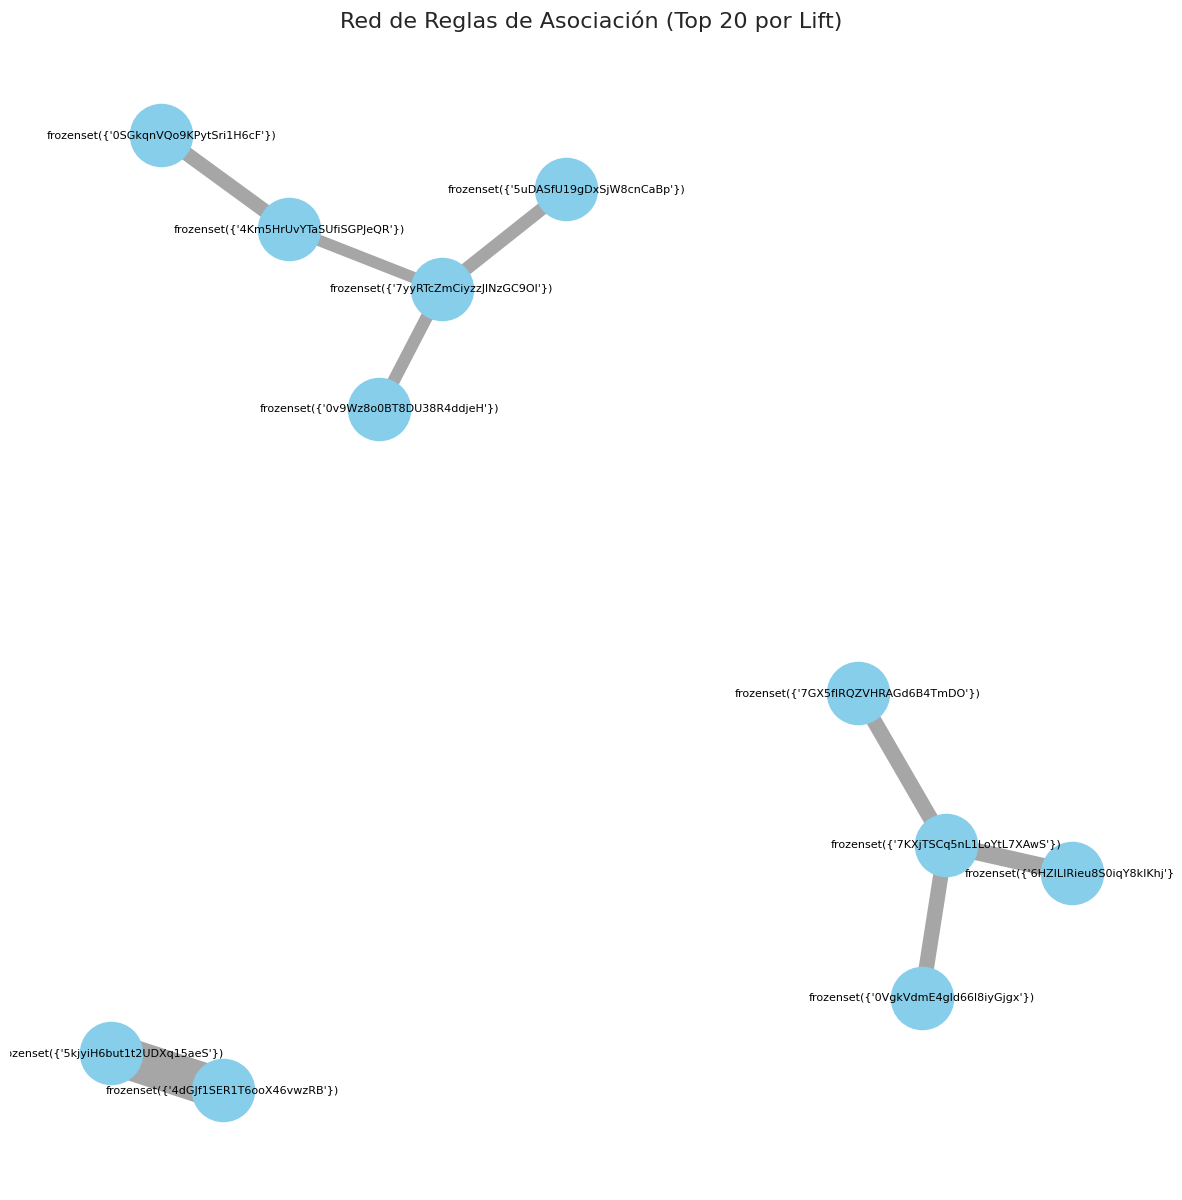

In [33]:
# --- 4.3 Entregables ---

# 1. Guardar las reglas en un archivo CSV
rules_output_path = Path("data/results")
rules_output_path.mkdir(parents=True, exist_ok=True)
significant_rules.to_csv(rules_output_path / "reglas_asociacion_significativas.csv", index=False)
print(f"Reglas guardadas en '{rules_output_path / 'reglas_asociacion_significativas.csv'}'")


# 2. Visualización: Gráfico de Red de las 20 reglas principales
# (Puede ser lento si hay muchas reglas)
top_rules = significant_rules.head(20)

plt.figure(figsize=(15, 15))
G = nx.from_pandas_edgelist(top_rules,
                           source='antecedents',
                           target='consequents',
                           edge_attr=['lift', 'confidence'])

# Posiciones de los nodos
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Dibujar nodos y etiquetas
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=8)

# Dibujar aristas con grosor basado en el lift
edge_width = [d['lift'] * 0.5 for (u, v, d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='gray', alpha=0.7)

plt.title('Red de Reglas de Asociación (Top 20 por Lift)')
plt.axis('off')
plt.show()

# 5: Clustering (Agrupación)
Dividiremos esta sección en dos partes, como se discutió: clustering de tracks y de playlists.

**Parte A: Clustering a Nivel de Canción (Track)**

Usaremos tracks_for_clustering para agrupar canciones con características de audio similares.

## 5.A.1 Algoritmo 1: K-Means con Búsqueda de K Óptimo

In [34]:
# --- 5.A.1 K-Means (Versión Corregida) ---
# Usamos el método del codo (Elbow Method) para encontrar un buen valor para k

X_tracks = tracks_for_clustering.copy() # Datos de entrada originales

# --- LA CORRECCIÓN ESTÁ AQUÍ ---
# K-Means solo puede trabajar con números. Nos aseguramos de seleccionar solo las columnas numéricas.
# El error 'could not convert string to float: 'Party'' indica que columnas de texto se colaron.
X_tracks_numeric = X_tracks.select_dtypes(include=np.number)

print(f"Shape original de X_tracks: {X_tracks.shape}")
print(f"Shape de X_tracks_numeric (solo columnas numéricas): {X_tracks_numeric.shape}\n")


# --- Continuación del código original, usando el DataFrame NUMÉRICO ---
inertia = []
K_range = range(2, 16) # Probaremos con k de 2 a 15

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    # Usamos el DataFrame NUMÉRICO para el ajuste
    kmeans.fit(X_tracks_numeric)
    inertia.append(kmeans.inertia_)

# Graficar el codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para encontrar k Óptimo')
plt.xticks(K_range)
plt.show()

# Basado en el gráfico, elegimos un valor para k (ej. k=8 donde la curva se aplana)
OPTIMAL_K = 8
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
# Usamos el DataFrame NUMÉRICO aquí también
track_labels_kmeans = kmeans.fit_predict(X_tracks_numeric)

print(f"\nClustering con K-Means completado usando k={OPTIMAL_K}.")

Shape original de X_tracks: (66243, 65)
Shape de X_tracks_numeric (solo columnas numéricas): (66243, 49)



KeyboardInterrupt: 

## 5.A.2 Algoritmos 2 y 3: DBSCAN y Agglomerative Clustering (reemplazado x MiniBatchKMeans)


In [ ]:

# # --- 5.A.2 Algoritmos 2 y 3: DBSCAN y Agglomerative Clustering (CORREGIDO) ---

# # --- DBSCAN ---
# # DBSCAN es bueno para encontrar clusters de formas arbitrarias y detectar ruido (outliers)
# # Sus hiperparámetros (eps, min_samples) son sensibles y requieren ajuste fino.
# print("Ejecutando DBSCAN...")
# dbscan = DBSCAN(eps=2.5, min_samples=15) # Estos valores son un punto de partida
# # LA CORRECCIÓN: Usamos X_tracks_numeric, no X_tracks
# track_labels_dbscan = dbscan.fit_predict(X_tracks_numeric)
# print("DBSCAN completado.")

# # --- Agglomerative Clustering ---
# # Crea una jerarquía de clusters.
# print("Ejecutando Agglomerative Clustering...")
# agglomerative = AgglomerativeClustering(n_clusters=OPTIMAL_K) # Usamos el mismo k que en KMeans
# # LA CORRECCIÓN: Usamos X_tracks_numeric, no X_tracks
# track_labels_agglomerative = agglomerative.fit_predict(X_tracks_numeric)
# print("Agglomerative Clustering completado.")


# # --- 5.A.3 Evaluación Comparativa y Visualización (CORREGIDO) ---
# print("\nCalculando métricas de evaluación...")

# # K-Means (ya lo tenías, pero lo incluimos para la tabla comparativa)
# score_s_kmeans = silhouette_score(X_tracks_numeric, track_labels_kmeans)
# score_db_kmeans = davies_bouldin_score(X_tracks_numeric, track_labels_kmeans)

# # DBSCAN (excluyendo ruido y usando el DataFrame numérico)
# mask_dbscan = track_labels_dbscan != -1
# # Nos aseguramos de que haya más de 1 clúster para poder evaluar
# if len(set(track_labels_dbscan[mask_dbscan])) > 1:
#     score_s_dbscan = silhouette_score(X_tracks_numeric[mask_dbscan], track_labels_dbscan[mask_dbscan])
#     score_db_dbscan = davies_bouldin_score(X_tracks_numeric[mask_dbscan], track_labels_dbscan[mask_dbscan])
# else:
#     score_s_dbscan = -1 # Valor inválido si no hay suficientes clusters
#     score_db_dbscan = -1

# # Agglomerative (usando el DataFrame numérico)
# score_s_agg = silhouette_score(X_tracks_numeric, track_labels_agglomerative)
# score_db_agg = davies_bouldin_score(X_tracks_numeric, track_labels_agglomerative)


# # Crear tabla de resultados
# results = pd.DataFrame({
#     'Algoritmo': ['K-Means', 'DBSCAN', 'Agglomerative'],
#     'Silhouette Score (más alto es mejor)': [score_s_kmeans, score_s_dbscan, score_s_agg],
#     'Davies-Bouldin Score (más bajo es mejor)': [score_db_kmeans, score_db_dbscan, score_db_agg]
# })

# print("\n--- Tabla Comparativa de Modelos de Clustering de Tracks ---")
# display(results)


# # --- Visualización de Clusters (usando los resultados de K-Means como ejemplo) ---
# viz_df = tracks_umap.copy()
# viz_df['cluster'] = track_labels_kmeans

# plt.figure(figsize=(12, 8))
# sns.scatterplot(
#     data=viz_df,
#     x='UMAP_1',
#     y='UMAP_2',
#     hue='cluster',
#     palette=sns.color_palette("hsv", n_colors=OPTIMAL_K),
#     s=10,
#     alpha=0.7,
#     legend='full'
# )
# plt.title(f'Visualización de Clusters de Canciones (K-Means, k={OPTIMAL_K})')
# plt.show()


In [ ]:
# --- 5.A.2 Algoritmos 2 y 3: DBSCAN y MiniBatchKMeans (CORREGIDO Y OPTIMIZADO) ---

# --- DBSCAN ---
# DBSCAN puede ser lento en datasets grandes. Sus hiperparámetros son clave.
# Si esta parte también es muy lenta, considera ejecutarla sobre una muestra o ajustar 'eps'.
print("Ejecutando DBSCAN...")
dbscan = DBSCAN(eps=2.5, min_samples=20, n_jobs=-1) # n_jobs=-1 usa todos los núcleos de tu CPU
track_labels_dbscan = dbscan.fit_predict(X_tracks_numeric)
print("DBSCAN completado.")


# --- MiniBatchKMeans (Reemplazo eficiente para Agglomerative Clustering) ---
# Este algoritmo es mucho más rápido y consume muchísima menos memoria.
print("Ejecutando MiniBatchKMeans...")
mini_batch_kmeans = MiniBatchKMeans(
    n_clusters=OPTIMAL_K, # Usamos el mismo k que en KMeans
    random_state=42,
    batch_size=256, # Tamaño del lote, un hiperparámetro a ajustar
    n_init=10
)
track_labels_minibatch = mini_batch_kmeans.fit_predict(X_tracks_numeric)
print("MiniBatchKMeans completado.")


# --- 5.A.3 Evaluación Comparativa y Visualización (CORREGIDO) ---
print("\nCalculando métricas de evaluación...")

# K-Means
score_s_kmeans = silhouette_score(X_tracks_numeric, track_labels_kmeans)
score_db_kmeans = davies_bouldin_score(X_tracks_numeric, track_labels_kmeans)

# DBSCAN (excluyendo ruido)
mask_dbscan = track_labels_dbscan != -1
if len(set(track_labels_dbscan[mask_dbscan])) > 1:
    # Usamos una muestra para el cálculo del score si es muy lento
    sample_indices = np.random.choice(X_tracks_numeric[mask_dbscan].index, size=min(20000, len(X_tracks_numeric[mask_dbscan])), replace=False)
    score_s_dbscan = silhouette_score(X_tracks_numeric.loc[sample_indices], track_labels_dbscan[mask_dbscan][sample_indices])
    score_db_dbscan = davies_bouldin_score(X_tracks_numeric.loc[sample_indices], track_labels_dbscan[mask_dbscan][sample_indices])
else:
    score_s_dbscan, score_db_dbscan = -1, -1

# MiniBatchKMeans
score_s_minibatch = silhouette_score(X_tracks_numeric, track_labels_minibatch)
score_db_minibatch = davies_bouldin_score(X_tracks_numeric, track_labels_minibatch)


# Crear tabla de resultados
results = pd.DataFrame({
    'Algoritmo': ['K-Means', 'DBSCAN', 'MiniBatchKMeans'],
    'Silhouette Score (más alto es mejor)': [score_s_kmeans, score_s_dbscan, score_s_minibatch],
    'Davies-Bouldin Score (más bajo es mejor)': [score_db_kmeans, score_db_dbscan, score_db_minibatch]
})

print("\n--- Tabla Comparativa de Modelos de Clustering de Tracks ---")
display(results)

# (El código de visualización que ya tenías funcionará igual)
# ...

# 5.A.3 Evaluación Comparativa y Visualización


In [ ]:
# # --- 5.A.3 Evaluación Interna ---
# # Calculamos Silhouette y Davies-Bouldin para los modelos
# # Nota: Para DBSCAN, excluimos los puntos de ruido (label -1) de la evaluación

# # K-Means
# score_s_kmeans = silhouette_score(X_tracks, track_labels_kmeans)
# score_db_kmeans = davies_bouldin_score(X_tracks, track_labels_kmeans)

# # DBSCAN (excluyendo ruido)
# mask_dbscan = track_labels_dbscan != -1
# score_s_dbscan = silhouette_score(X_tracks[mask_dbscan], track_labels_dbscan[mask_dbscan])
# score_db_dbscan = davies_bouldin_score(X_tracks[mask_dbscan], track_labels_dbscan[mask_dbscan])

# # Agglomerative
# score_s_agg = silhouette_score(X_tracks, track_labels_agglomerative)
# score_db_agg = davies_bouldin_score(X_tracks, track_labels_agglomerative)


# # Crear tabla de resultados
# results = pd.DataFrame({
#     'Algoritmo': ['K-Means', 'DBSCAN', 'Agglomerative'],
#     'Silhouette Score (más alto es mejor)': [score_s_kmeans, score_s_dbscan, score_s_agg],
#     'Davies-Bouldin Score (más bajo es mejor)': [score_db_kmeans, score_db_dbscan, score_db_agg]
# })

# print("--- Tabla Comparativa de Modelos de Clustering de Tracks ---")
# print(results)


# # --- Visualización de Clusters (usando los resultados de K-Means como ejemplo) ---
# # Usamos el UMAP que precalculamos en el notebook anterior
# viz_df = tracks_umap.copy()
# viz_df['cluster'] = track_labels_kmeans

# plt.figure(figsize=(12, 8))
# sns.scatterplot(
#     data=viz_df,
#     x='UMAP_1',
#     y='UMAP_2',
#     hue='cluster',
#     palette=sns.color_palette("hsv", n_colors=OPTIMAL_K),
#     s=10,
#     alpha=0.7,
#     legend='full'
# )
# plt.title(f'Visualización de Clusters de Canciones (K-Means, k={OPTIMAL_K})')
# plt.show()

In [ ]:
# --- 5.A.3 Evaluación Comparativa y Visualización (MODIFICADO Y CORREGIDO) ---

print("\nCalculando métricas de evaluación...")

# --- K-Means ---
# CORREGIDO: Usamos X_tracks_numeric para el cálculo de los scores.
print("Evaluando K-Means...")
score_s_kmeans = silhouette_score(X_tracks_numeric, track_labels_kmeans)
score_db_kmeans = davies_bouldin_score(X_tracks_numeric, track_labels_kmeans)

# --- DBSCAN ---
# CORREGIDO: Usamos X_tracks_numeric y mantenemos la optimización de muestreo para el cálculo.
print("Evaluando DBSCAN...")
mask_dbscan = track_labels_dbscan != -1 # Filtro para excluir puntos de ruido (label -1)

# Nos aseguramos de que DBSCAN haya encontrado más de 1 clúster para poder evaluar
if len(set(track_labels_dbscan[mask_dbscan])) > 1:
    # Usamos una muestra para que el cálculo del score sea rápido en datasets grandes
    # Tomamos una muestra de hasta 20,000 puntos que no sean ruido
    sample_size = min(20000, np.sum(mask_dbscan))
    sample_indices = np.random.choice(X_tracks_numeric[mask_dbscan].index, size=sample_size, replace=False)

    score_s_dbscan = silhouette_score(X_tracks_numeric.loc[sample_indices], track_labels_dbscan[sample_indices])
    score_db_dbscan = davies_bouldin_score(X_tracks_numeric.loc[sample_indices], track_labels_dbscan[sample_indices])
else:
    # Si DBSCAN no encontró clusters (o solo uno), asignamos un score inválido
    print("DBSCAN no encontró suficientes clusters para ser evaluado.")
    score_s_dbscan = -1
    score_db_dbscan = -1

# --- MiniBatchKMeans ---
# NUEVO: Reemplazamos la evaluación de Agglomerative por la de MiniBatchKMeans.
print("Evaluando MiniBatchKMeans...")
score_s_minibatch = silhouette_score(X_tracks_numeric, track_labels_minibatch)
score_db_minibatch = davies_bouldin_score(X_tracks_numeric, track_labels_minibatch)


# --- Crear tabla de resultados ---
# CORREGIDO: Actualizamos la lista de algoritmos y las variables de los scores.
results = pd.DataFrame({
    'Algoritmo': ['K-Means', 'DBSCAN', 'MiniBatchKMeans'],
    'Silhouette Score (más alto es mejor)': [score_s_kmeans, score_s_dbscan, score_s_minibatch],
    'Davies-Bouldin Score (más bajo es mejor)': [score_db_kmeans, score_db_dbscan, score_db_minibatch]
})

print("\n--- Tabla Comparativa de Modelos de Clustering de Tracks ---")
display(results)


# --- Visualización de Clusters ---
# Este bloque no necesita cambios, pero lo mantenemos por completitud.
# Muestra los resultados de K-Means como ejemplo.
# Nota: Para visualizar otros resultados, simplemente cambia 'track_labels_kmeans'
# por 'track_labels_minibatch' o 'track_labels_dbscan'.

print("\nGenerando visualización de clusters (ejemplo con K-Means)...")
viz_df = tracks_umap.copy()
viz_df['cluster'] = track_labels_kmeans

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=viz_df,
    x='UMAP_1',
    y='UMAP_2',
    hue='cluster',
    palette=sns.color_palette("hsv", n_colors=OPTIMAL_K),
    s=10, # Tamaño de los puntos
    alpha=0.7,
    legend='full'
)
plt.title(f'Visualización de Clusters de Canciones (K-Means, k={OPTIMAL_K})')
plt.show()

**Parte B: Clustering a Nivel de Playlist**

Aquí realizamos el paso de agregación que faltaba (nivel de playlists)

## 5.B.1 Preparar Vectores de Features de Playlists


In [ ]:
# --- 5.B.1 Agregación a Nivel de Playlist ---
print("Iniciando la agregación de features a nivel de playlist...")
# Seleccionar columnas numéricas de audio
numerical_cols = tracks_for_clustering.columns

# --- LA CORRECCIÓN ESTÁ AQUÍ ---
# 1. Seleccionamos SOLO las columnas numéricas del DataFrame que vamos a agrupar.
numerical_cols_all = df_processed.select_dtypes(include=np.number).columns

# 2. Excluimos explícitamente las columnas que son numéricas pero NO son features de audio.
#    No tiene sentido promediar el 'pid', la 'pos' o la bandera 'was_imputed'.
cols_to_exclude = ['pid', 'pos', 'was_imputed']
numerical_features = [col for col in numerical_cols_all if col not in cols_to_exclude]

print(f"Se promediarán {len(numerical_features)} columnas de features para cada playlist.")


# 3. Agrupamos por playlist (pid) y calculamos la media usando la lista de columnas correcta.
#    Esta operación ahora solo funcionará con verdaderas features numéricas.
playlist_features_df = df_processed.groupby('pid')[numerical_features].mean()


# ¡Importante! El resto del código ya estaba bien.
# Debemos escalar estas nuevas features agregadas para que los algoritmos de clustering funcionen bien.
scaler_playlist = MinMaxScaler()
playlist_features_scaled = scaler_playlist.fit_transform(playlist_features_df)
playlist_features_scaled_df = pd.DataFrame(playlist_features_scaled, index=playlist_features_df.index, columns=playlist_features_df.columns)


print("\nDataFrame para clustering de playlists creado y escalado exitosamente.")
display(playlist_features_scaled_df.head())

## 5.B.2 Aplicar Clustering y Visualizar con Gráfico Radar
Aplicaremos K-Means como ejemplo y crearemos el gráfico radar para interpretar los clusters.

In [ ]:
# --- 5.B.2 K-Means para Playlists y Gráfico Radar ---

# Usaremos un k diferente, por ejemplo k=6 para playlists
K_PLAYLISTS = 6
kmeans_playlist = KMeans(n_clusters=K_PLAYLISTS, random_state=42, n_init=10)
playlist_labels = kmeans_playlist.fit_predict(playlist_features_scaled_df)

# Añadir las etiquetas de cluster al dataframe escalado
playlist_features_scaled_df['cluster'] = playlist_labels


# --- Gráfico Radar para interpretar los clusters ---
# Calculamos los centroides (el perfil promedio de cada cluster)
centroids = playlist_features_scaled_df.groupby('cluster').mean()

# Preparar para el gráfico
labels = centroids.columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] # Repetir el primer ángulo para cerrar el círculo

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for i, row in centroids.iterrows():
    values = row.values.flatten().tolist()
    values += values[:1] # Repetir el primer valor
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title('Perfil Promedio de Clusters de Playlists (Gráfico Radar)', size=20, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()